In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
import pymc as pm
from properscoring import crps_ensemble
import random
from patsy import dmatrix
import arviz as az
import matplotlib.pyplot as plt
import gc

from joblib import Parallel, delayed
from tqdm import tqdm

sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds
from model_tools.NegativeBinomial import NegBin as NB

M = 50
D = 40
N= 1000
chains = 2


start_year = 2022
end_year = 2022
seed = 123

# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M, norm=False)
true_count_dataset = TrueCountDataset(delays_df)

class PropBNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        window_dates = [date - pd.Timedelta(days=i) for i in range(M)]
        window_dates = sorted(window_dates)
        Z_obs = self.partial_count_obj.get_obs(date)
        y_true = [self.true_count_obj.get_y(day) for day in window_dates]
        z_true = [self.true_count_obj.get_z(day) for day in window_dates]
        y_true = np.array(y_true).reshape(M)
        dow = date.day_of_week
        return Z_obs, y_true, z_true, window_dates

set_seed(seed)

# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))

T = len(dates)
# T = 8
    
dataset = PropBNNDataset(partial_count_dataset, true_count_dataset, dates)


def silu(x):
    return x * pm.math.sigmoid(x)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        cores=1,
        init="adapt_diag",
        chains=chains,
        draws=N,
        tune=500,
        target_accept=0.95,
        max_treedepth=10,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

def get_mask(D):
        mask_matrix = np.ones(shape=(D, D), dtype=bool)
        for i in range(D):
            for j in range(D):
                if i + j > D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix

def create_fourier_features(t, n, p=10.0):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)


In [ ]:
# Constants
t = np.arange(0, M)
t_week = t % 14
t_norm = t / M

n = 14
fourier_basis_biweek = create_fourier_features(t, n=n, p=3.5)
fourier_basis_week = create_fourier_features(t, n=n, p=7)

fourier_basis_biweek = fourier_basis_biweek - fourier_basis_biweek.mean(0, keepdims=True)
fourier_basis_week = fourier_basis_week - fourier_basis_week.mean(0, keepdims=True)



spline_week = dmatrix(
    "cc(t_week, df=7)", {"t_week": t_week}, return_type='dataframe'
)
X_week = np.asarray(spline_week)

t_input = np.arange(M)[:, None] / M
time_input = np.concatenate([t_input, fourier_basis_biweek, fourier_basis_week], axis=1)

mask = np.ones((M,D), dtype=bool)
mask[-D:,:] = get_mask(D)




In [ ]:
def run_PropBNN(Z_obs, Z_norm):
    with pm.Model() as PropBNN:
       
        const = pm.Normal("const", mu=pm.math.log(Z_obs.mean()+1), sigma=0.3)

        beta_linear = pm.Normal("beta_linear", mu=0, sigma=0.3)

        # Trend spline coefficients
        sigma_week = pm.HalfNormal("sigma_week", 0.3)
        raw_week = pm.Normal("raw_week", mu=0, sigma=1, shape=X_week.shape[1])
        beta_week = pm.Deterministic("beta_week", raw_week*sigma_week)
        week_spline = pm.math.dot(X_week, beta_week)

        sigma_eps = pm.HalfNormal("sigma_eps", 0.3)
        eps = pm.Normal("eps", mu=0, sigma=sigma_eps, shape=M)

        # Create lam param 
        log_lam = pm.Deterministic(
                "log_lam",  const + beta_linear*t_norm + week_spline + eps
            )

        # NN for proportions from time inputs
        n_hidden = 16
        sigma_net = 0.3
        
        W1 = pm.Normal("W1", 0, sigma_net, shape=(1+4*n, n_hidden))
        b1 = pm.Normal("b1", 0, sigma_net, shape=(n_hidden,))
        h1 = silu(pm.math.dot(time_input, W1) + b1)

        W2 = pm.Normal("W2", 0, sigma_net, shape=(n_hidden, D))
        b2 = pm.Normal("b2", 0, sigma_net, shape=(D,))
        p_raw = pm.math.dot(h1, W2) + b2
        log_p = pm.math.log_softmax(p_raw, axis=1)


        # Make mu param per tim/delay point
        log_mu = log_lam[:, None] + log_p
        mu = pm.Deterministic("mu", pm.math.exp(log_mu))

        # Overdispersion
        theta = pm.Exponential("theta", lam=1/(Z_obs.mean()+1))

        # Observed data
        z = pm.NegativeBinomial("z", mu[mask], theta, observed=Z_obs[mask])

        # Generated Quantities
        p = pm.Deterministic("p", pm.math.exp(log_p))
        lam = pm.Deterministic("lam", pm.math.exp(log_lam))

        idata = pm.sample(progressbar=True, **sampler_kwargs())

    
    return idata

In [4]:
def run_single(idx):
    save_path = f"/Volumes/GLENN_SSD/V2/PropBNN_idata_{idx}.nc"
    n_retries = 5
    for run in range(n_retries):
        try:
            Z_obs, _, _, _ = dataset.__getitem__(idx)
            Z_norm = (Z_obs - Z_obs.mean()) / (Z_obs.std() + 1e-6)
            idata = run_PropBNN(Z_obs, Z_norm)
            idata = idata.posterior[['mu', 'theta']]
            az.to_netcdf(idata, save_path)
            del idata
            gc.collect()
            break
        except Exception as e:
            print(f"Time point {idx} failed: {e}. Retrying...")

    

mu_samples = np.zeros((T, M, D, N))
theta_samples = np.zeros((T, M,1,N ))
T_range = range(40,60)
results = Parallel(n_jobs=2)(
    delayed(run_single)(idx) for idx in tqdm(T_range)
)


 20%|██        | 4/20 [03:14<12:57, 48.58s/it]

KeyboardInterrupt: 

In [ ]:

mu_samples = np.ones((T, D, chains*N))
theta_samples = np.ones((T, D, chains*N))
z_samples = np.zeros((T, D, chains*N))

# for idx in range(T):
for idx in range(T):
    path = f"/Volumes/GLENN_SSD/V2/PropBNN_idata_{idx}.nc"
    idata = az.from_netcdf(path)
    mu = az.extract(idata, group='posterior')['mu'][-1, :, :]
    theta = az.extract(idata, group='posterior')['theta']
    
    if len(theta.shape) == 1:
        theta = np.expand_dims(theta, axis=0)
    else:
        theta = theta[-1, :, :]

    theta = np.broadcast_to(theta, mu.shape)

    p = theta / (theta + mu)
    z = np.random.negative_binomial(theta, p, size=mu.shape)
    
    mu_samples[idx, :, :] = mu
    theta_samples[idx, :, :] = theta
    z_samples[idx, :, :] = z

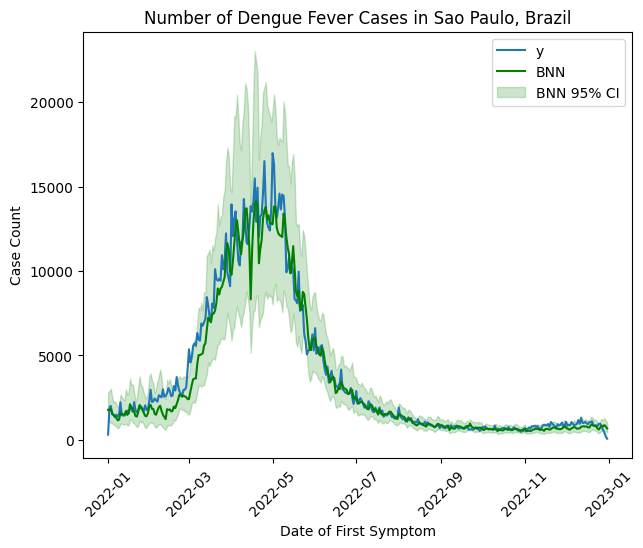

In [ ]:
y_pred = z_samples.sum(1)
y_pred.shape


y_true = [dataset.__getitem__(idx)[1][-1] for idx in range(T)]
window_dates = [dataset.__getitem__(idx)[3][-1] for idx in range(T)]

y_pred_med = np.quantile(y_pred, 0.5, axis=1)
y_pred_lower = np.quantile(y_pred, 0.025, axis=1)
y_pred_upper = np.quantile(y_pred, 0.975, axis=1)

plt.plot(window_dates, y_true, label='y')

plt.plot(window_dates, y_pred_med, label='BNN', color='green')
plt.fill_between(window_dates, y_pred_lower, y_pred_upper, color='green', alpha=0.2, label='BNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

